#By: Pranav Raj

##Importing Libraries

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


  * Here we will be using the dataset of the quarterly earnings per share (EPS) of Johnson&Johnson.

  * The dataset of the quarterly earnings per share (EPS) of Johnson&Johnson.


In [ ]:
# reading data
data = pd.read_csv("drive/My Drive/jj.csv")                 
data.head()

,date,data
0,01/01/60,0.71
1,01/04/60,0.63
2,02/07/60,0.85
3,01/10/60,0.44
4,01/01/61,0.61


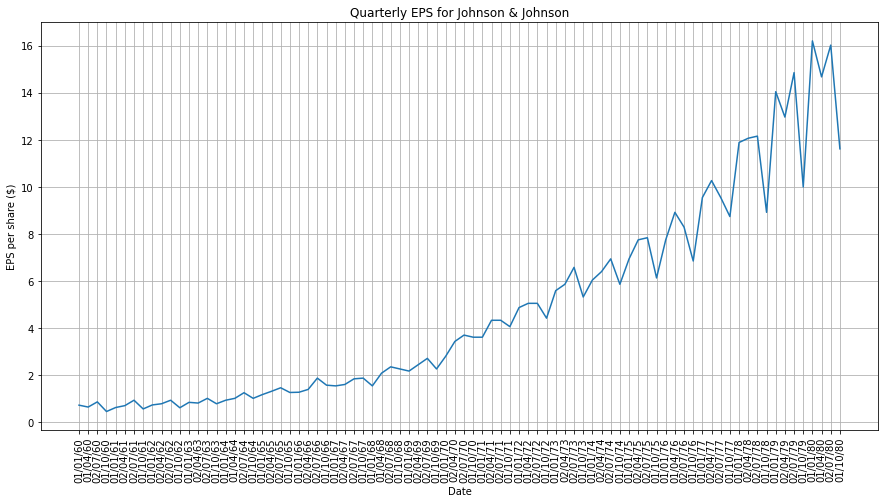

In [ ]:
# we can display a plot of the time series:

plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['date'], data['data'])
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Clearly, the time series is not stationary, as its mean is not constant through time, and we see an increasing variance in the data, a sign of heteroscedasticity.

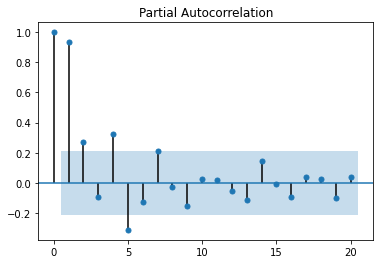

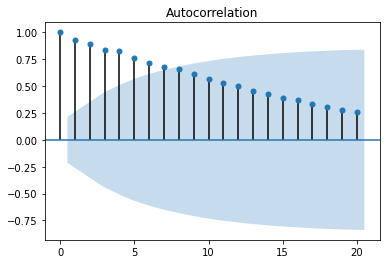

In [ ]:
# To make sure, let’s plot the PACF and ACF:

plot_pacf(data['data']);
plot_acf(data['data']);

Again, no information can be deduced from those plots. You can further test for stationarity with the Augmented Dickey-Fuller test:

In [ ]:
ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.742016573457476
p-value: 1.0


Since the p-value is large, we cannot reject the null hypothesis and must assume that the time series is non-stationary.

Now, let’s take the log difference in an effort to make it stationary:

In [ ]:
data['data'] = np.log(data['data'])
data['data'] = data['data'].diff()
data = data.drop(data.index[0])

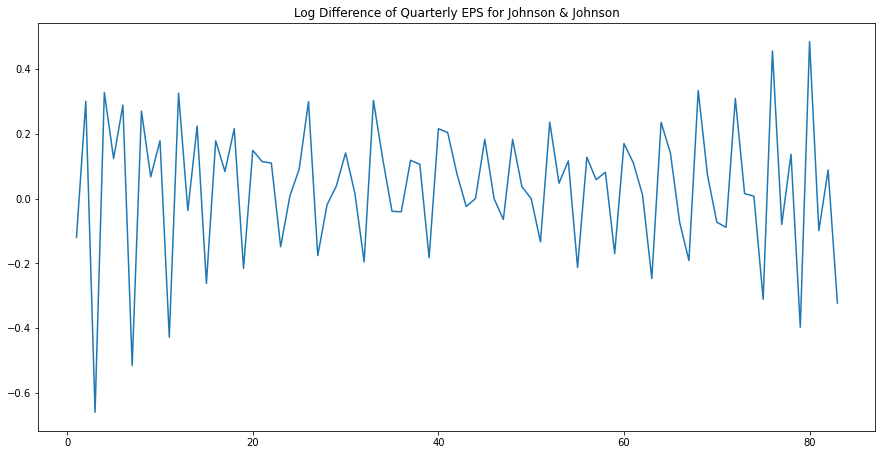

In [ ]:
#Plotting the new data should give:

plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

Now, we still see the seasonality in the plot above. Since we are dealing with quarterly data, our period is 4. Therefore, we will take the difference over a period of 4

In [ ]:
# Seasonal differencing
data['data'] = data['data'].diff(4)
data = data.drop([1, 2, 3, 4], axis=0).reset_index(drop=True)

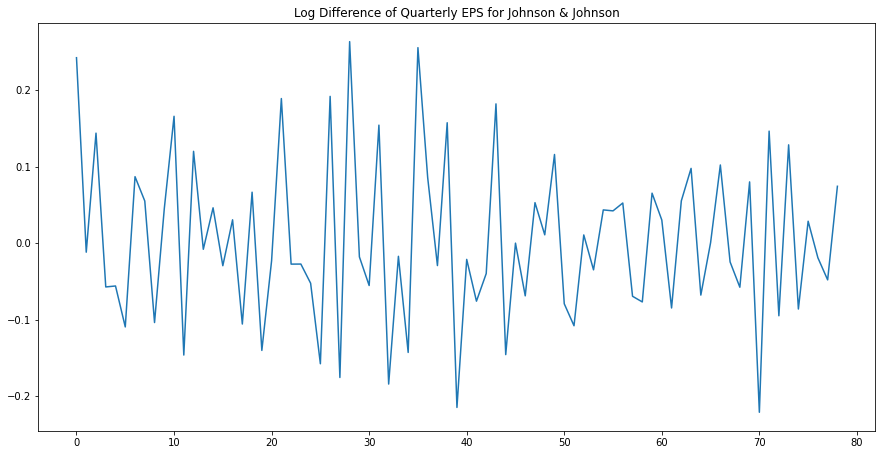

In [ ]:
# Plotting the new data

plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

Keep in mind that although we took the difference over a period of 4 months, the order of seasonal differencing (D) is 1, because we only took the difference once.

Now, let’s run the Augmented Dickey-Fuller test again to see if we have a stationary time series:

In [ ]:
ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.630805109914263
p-value: 5.72157869513621e-09


Indeed, the p-value is small enough for us to reject the null hypothesis, and we can consider that the time series is stationary.


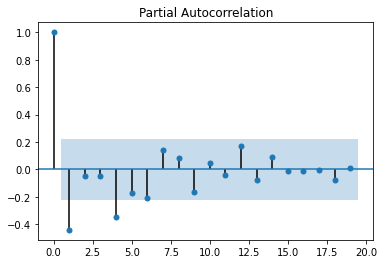

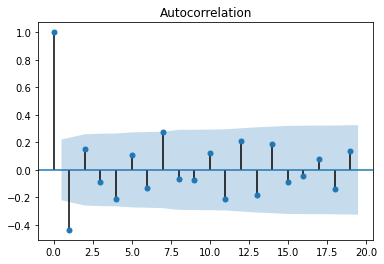

In [ ]:
# Taking a look at the ACF and PACF:

plot_pacf(data['data']);
plot_acf(data['data']);

We can see from the PACF that we have a significant peak at lag 1, which suggest an AR(1) process. Also, we have another peak at lag 4, suggesting a seasonal autoregressive process of order 1 (P = 1).
Looking at the ACF plot, we only see a significant peak at lag 1, suggesting a non-seasonal MA(1) process.

Although these plots can give us a rough idea of the processes in play, it is better to test multiple scenarios and choose the model that yield the lowest AIC.

Therefore, let’s write a function that will test a series of parameters for the SARIMA model and output a table with the best performing model at the top:


In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
#generating all possible parameters combination

p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


We get 256 unique combinations! Now, our function will fit 256 different SARIMA models on our data to find the one with the lowest AIC

In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, data['data'])
result_df

From the table, you can see that the best model is: SARIMA(0, 1, 2)(0, 1, 2, 4).

Now, we will fit the model and output its summary.

In [ ]:
best_model = SARIMAX(data['data'], order=(0, 1, 2), seasonal_order=(0, 1, 2, 4)).fit(dis=-1)
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                              data   No. Observations:                   79
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 4)   Log Likelihood                  62.228
Date:                           Sun, 24 Jul 2022   AIC                           -114.457
Time:                                   15:56:44   BIC                           -102.937
Sample:                                        0   HQIC                          -109.861
                                            - 79                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5858      0.143    -11.078      0.000      -1.866      -1.305
ma.L2          0.5954      0.113      5.249

Here, you see that the best performing model has both seasonal and non-seasonal moving average processes.

From the summary above, you can find the value of the coefficients and their p-value. Notice that from the p-value, all coefficients are significant

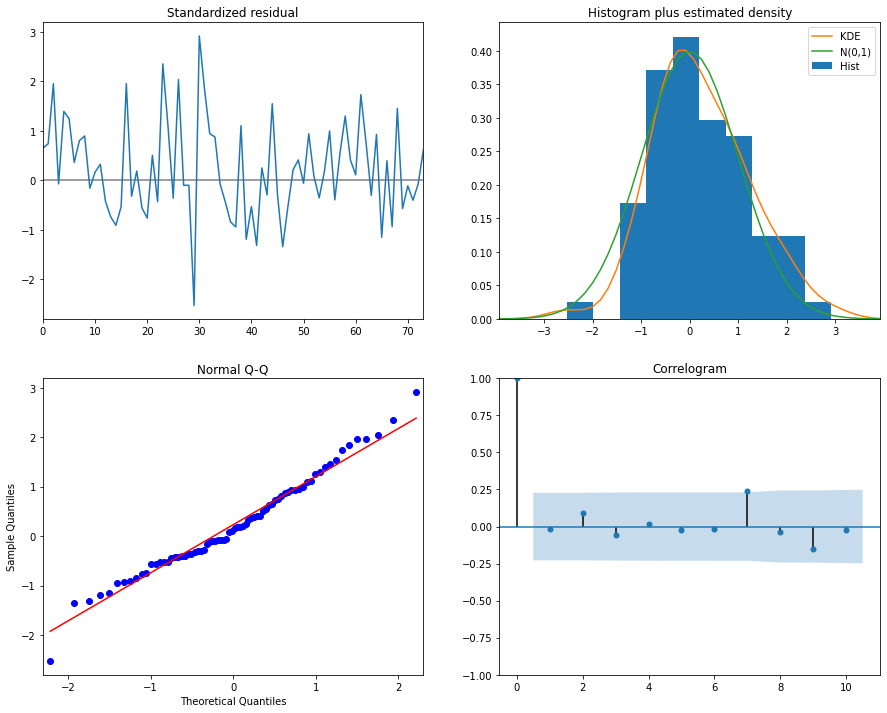

In [ ]:
#we can study the residuals:

best_model.plot_diagnostics(figsize=(15,12));

From the normal Q-Q plot, we can see that we almost have a straight line, which suggest no systematic departure from normality. 

Also, the correlogram on the bottom right suggests that there is no autocorrelation in the residuals, and so they are effectively white noise.

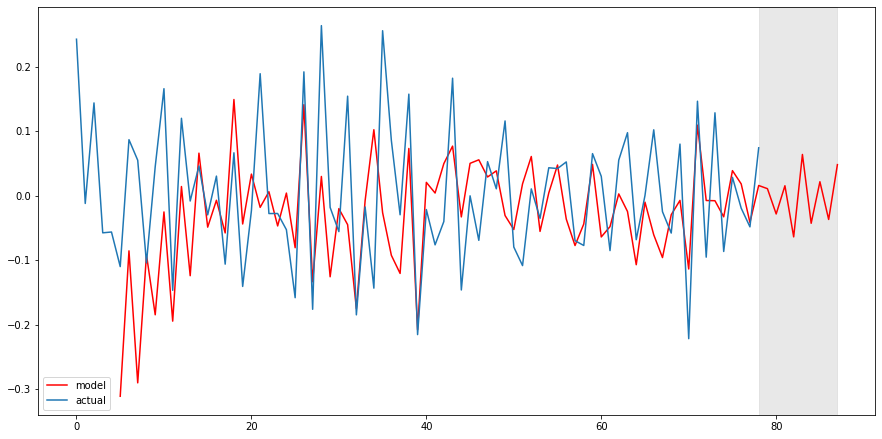

In [ ]:
#We are ready to plot the predictions of our model and forecast into the future:

data['arima_model'] = best_model.fittedvalues
data['arima_model'][:4+1] = np.NaN
forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 8)
forecast = data['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['data'], label='actual')
plt.legend()
plt.show()

**Conclusion**:

We now understand what a seasonal ARIMA (or SARIMA) model is and how to use it to model and forecast.